# О вкусной и здоровой пище 
**Restaurant Rating prediction Kochkin Dmitriy**

- Restaurant_id — идентификационный номер ресторана / сети ресторанов;
- City — город, в котором находится ресторан;
- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
- **Rating** — рейтинг ресторана по данным TripAdvisor (**именно это значение должна будет предсказывать модель**);
- Price Range — диапазон цен в ресторане;
- Number of Reviews — количество отзывов о ресторане;
- Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
- URL_TA — URL страницы ресторана на TripAdvisor;
- ID_TA — идентификатор ресторана в базе данных TripAdvisor.




Данные разбиты на обучающую и тестовую выборку - по обучающей выборке мы производим обучение модели и валидацию, а по тестовой только делаем предсказания - мы не можете на ней самостоятельно оценить качество модели, потому что у вас нет для нее эталонных значений зависимой переменной.





# План работы над признаками:


**Restaurant_id:**

- Возвращаем только номер id.
- Находим повторяющиеся id и узнаем: можно ли отнести ресторан к сетевому?

**City:**

- Дополнительно вносим информацию о численности населения.
- Добавляем фильтр по столицам.
- Добавляем информацию о покупательской способности населения.
- Помечаем, входит ли город в топ популярных.
- Вычисляем количество ресторанов для города в каждой строке.
- Вычисляем количество ресторанов на человека.

**Cuisine Style:**

- Обрабатываем признак и заполняем пропуски.
- Создаем новый признак с количеством кухонь в каждом ресторане.
- Разбиваем признак на dummy переменные.
- Находим самые популярные кухни.
- Узнаем относится ли что-то к этому топу в каждой строке.
- Создаем признак, который отвечает на вопрос: количество кухонь больше или меньше чем в среднем в каждом ресторане?

**Ranking:**

- Добавим переменные со средним, максимальным и минимальным рангами ресторана по городу.
- Нормализуем данные.

**Price Range:**

- Перекодируем Price Range и удаляем NaN.
- Добавим переменную соотношение цен в ресторане и модальной цены.
- Найдем относительный ценовой диапазон.


**Number of Reviews:**

- Нормализуем данные с помощью логарифмизаци. 
- Заменим выбросы крайними значениями.
- Узнаем как часто оставляются отзывы.
- Узнаем ранк ресторана с учетом частоты отзывов в городе.

**Reviews:**

- Выделяем даты из отзывов.
- Очищаем данные для анализа
- Удалим вторую дату (дубликат первой), если отзыв был всего один
- Переведём данные в формат datetime.strptime для удобства дальнейшей работы.
- Cоздаём колонки, показывающие сколько дней назад были написаны отзывы. Точкой отсчета возьмем 01.01.2021 года.
- Если пропущены значения, то заменим на среднее.
- Заменим отсутствующие значения на модальные даты.
- Создаём колонки с днями недели отзывов и месяцы.
- Ранжируем столбцы с датами отзывов и столбец с днями между отзывами.

# Импорт:

In [1]:
# Импорт различных библиотек.

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

import re

from itertools import combinations
from scipy.stats import ttest_ind

import warnings
import random

warnings.simplefilter('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import rankdata

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

# Добавим метод чтобы красиво отобржать текст
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


# Загрузка датасета:

In [2]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

# Функции:

# Предосмотр данных

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Для воспроизводимости результатов зададим:
# общий параметр для генерации случайных чисел
RANDOM_SEED = 20726
# актуальную дату
ACTUAL_DATE = pd.to_datetime('31/08/2021')

In [4]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет

df_train['sample'] = 1 # помечаем где у нас трейн (для кагла)
df_test['sample'] = 0 # помечаем где у нас тест 
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
food = data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


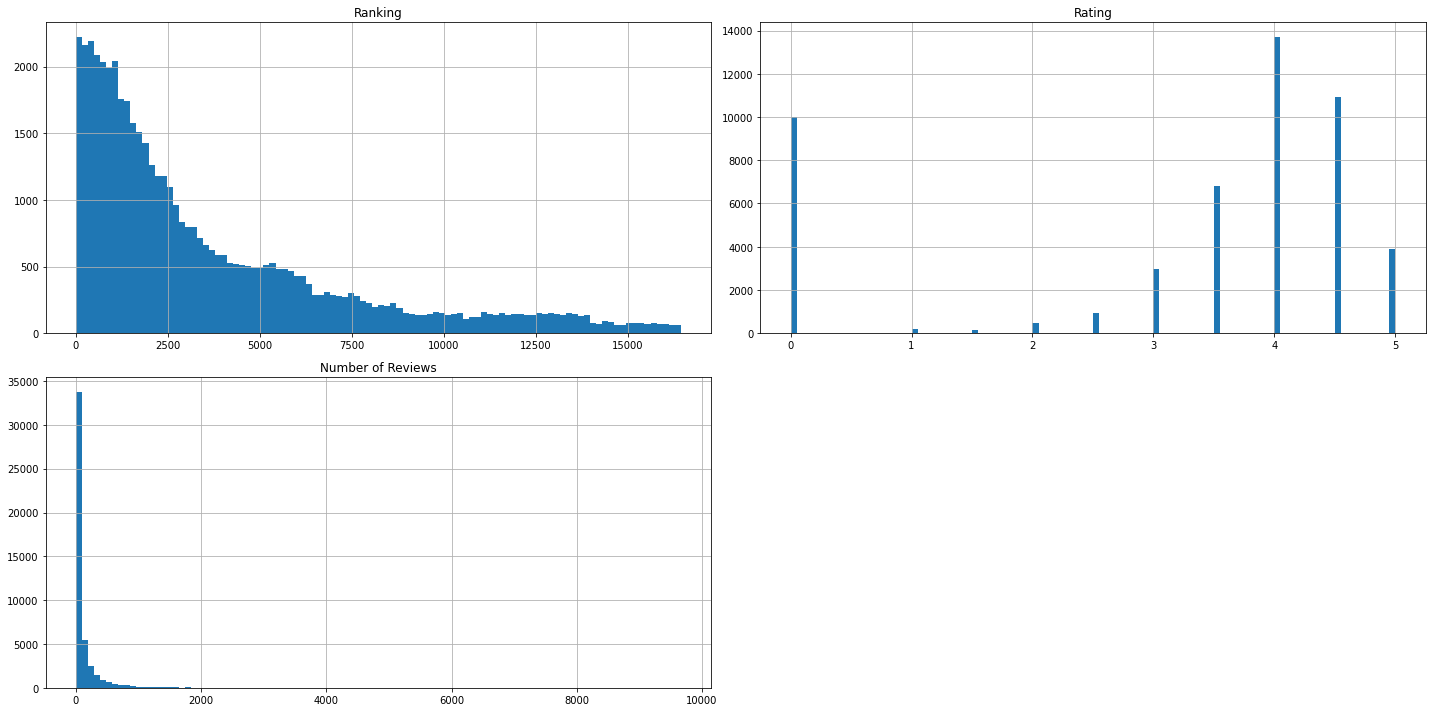

In [5]:
# Рассмотрим распределение числовых признаков.

food[['Ranking', 'Rating', 'Number of Reviews']].hist(figsize=(20, 10), bins=100);
plt.tight_layout()

In [6]:
food

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0


# Обработка и создание признаков:

### Restaurant_id

In [7]:
#food['Restaurant_id'].apply(lambda x: x.split('_')[1]).astype(int).hist(figsize=(10,5), bins=100); 
#plt.tight_layout() #Возвращаем только номер id и приводим к int.

#Restaurant_id похож на Ranking.

In [8]:
food['Restaurant_id'].value_counts()

# Можно заметить, что некоторые из ресторанов являются сетевыми.

id_871      19
id_227      19
id_436      19
id_633      19
id_585      18
            ..
id_7929      1
id_12865     1
id_12541     1
id_12097     1
id_10831     1
Name: Restaurant_id, Length: 13094, dtype: int64

In [9]:
# Сетевой ID ресторана (похоже, что это ID франшизы, поэтому если повторяется более 1-го раза - isNetworkRestorant)

import warnings; warnings.simplefilter('ignore')
food['Restaurant_id'] = food['Restaurant_id'].apply(lambda x: x.split('_')[1])
NetworkRestorants = food[food['Restaurant_id'].isin(food['Restaurant_id'].value_counts()[food['Restaurant_id'].value_counts()>2].index)]
NetworkRestorants['isNetworkRestorant'] = 1
food['isNetworkRestorant'] = NetworkRestorants['isNetworkRestorant']
food['isNetworkRestorant'] = food['isNetworkRestorant'].fillna(0)

### City

In [10]:
# Дополнительно вносим информацию о численности населении в каждом из городов.

population = {
    'London' : 8909081,
    'Paris' : 2148271,
    'Madrid' : 3223334,
    'Barcelona' : 1620343,
    'Berlin' : 3769495,
    'Milan' : 1399860,
    'Rome' : 2860009,
    'Prague' : 1324277,
    'Lisbon' : 505526,
    'Vienna' : 2600000,
    'Amsterdam' : 872680,
    'Brussels' : 1208542,
    'Hamburg' : 1845229,
    'Munich' : 1484226,
    'Lyon' : 516092,
    'Stockholm' : 975904,
    'Budapest' : 1752286,
    'Warsaw' : 1793579,
    'Dublin' : 554554,
    'Copenhagen' : 794128,
    'Athens' : 664046,
    'Edinburgh' : 488050, 
    'Zurich' : 415215,
    'Oporto' : 287591,
    'Geneva' : 201818, 
    'Krakow' : 779115, 
    'Oslo' : 697549, 
    'Helsinki' : 656229,
    'Bratislava' : 437726,
    'Luxembourg' : 626108,
    'Ljubljana' : 295504
}

food['Population'] = food['City'].map(population)

In [11]:
# Добавим фильтр по столицам. 

capital = ['London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague',
          'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Stockholm',
          'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Athens',
          'Edinburgh', 'Oslo', 'Helsinki', 'Bratislava',
          'Luxembourg', 'Ljubljana']

food['is_it_capital'] = food['City'].apply(lambda x: 1 if x in capital else 0)

In [12]:
# Добавим информацию о покупательной способности населения.

purchasing_power_index = {
    'London' : 24,
    'Paris' : 22,
    'Madrid' : 23,
    'Barcelona' : 30,
    'Berlin' : 8,
    'Milan' : 40,
    'Rome' : 37,
    'Prague' : 31,
    'Lisbon' : 48,
    'Vienna' : 21,
    'Amsterdam' : 19,
    'Brussels' : 15,
    'Hamburg' : 7,
    'Munich' : 6,
    'Lyon' : 70,
    'Stockholm' : 13,
    'Budapest' : 51,
    'Warsaw' : 29,
    'Dublin' : 27,
    'Copenhagen' : 10,
    'Athens' : 53,
    'Edinburgh' : 16, 
    'Zurich' : 2,
    'Oporto' : 42,
    'Geneva' : 3, 
    'Krakow' : 36, 
    'Oslo' : 17, 
    'Helsinki' : 9,
    'Bratislava' : 39,
    'Luxembourg' : 4,
    'Ljubljana' : 32
}

food['purchasing_power'] = food['City'].map(purchasing_power_index)

In [13]:
# Помечаем, входит ли город в топ популярных городов.

top_Cityes = food['City'].value_counts()[0:10].index.to_list()
food['TopCityes'] = food['City'].apply(lambda x: 1 if x in top_Cityes else 0)

In [14]:
# Вычисляем к-во ресторанов для города в каждой строке.

restorants_in_city = food.groupby('City')['Ranking'].count().to_dict()
food['Restaurants Count'] = food['City'].map(restorants_in_city)

In [15]:
# Вычисляем количество ресторанов на человека для города в каждой строке.

food['Restaurants for Population'] = food['Restaurants Count'] / (food['Population'])

### Cousine Style:

In [16]:
# Если в ресторане не заполнена информация о типах кухни, которую готовят, 
# можно предположить, что в этом ресторане только местная кухня. 
# Поэтому заменили ее константой Local.

food['Cuisine Style'] = food['Cuisine Style'].fillna("['local']")

In [17]:
# Привидем данные в столбце Cuisine Style к нормальному виду

food['Cuisine Style'] = food['Cuisine Style'].apply(lambda x: eval(x))

In [18]:
# Добавим переменную с количеством типов кухонь.

food['len_cuisines'] = food['Cuisine Style'].apply(lambda x: len(x))

In [19]:
# Добавим дамми переменные по типам кухонь.

style = food['Cuisine Style'].explode()
X = pd.get_dummies(style)
index_list = pd.Index.tolist(X.index)
Y = X.groupby(index_list).sum()
food = food.join(Y)

In [20]:

list_style = food[['Afghani',
 'African',
 'Albanian',
 'American',
 'Arabic',
 'Argentinean',
 'Armenian',
 'Asian',
 'Australian',
 'Austrian',
 'Azerbaijani',
 'Balti',
 'Bangladeshi',
 'Bar',
 'Barbecue',
 'Belgian',
 'Brazilian',
 'Brew Pub',
 'British',
 'Burmese',
 'Cafe',
 'Cajun & Creole',
 'Cambodian',
 'Canadian',
 'Caribbean',
 'Caucasian',
 'Central American',
 'Central Asian',
 'Central European',
 'Chilean',
 'Chinese',
 'Colombian',
 'Contemporary',
 'Croatian',
 'Cuban',
 'Czech',
 'Danish',
 'Delicatessen',
 'Diner',
 'Dutch',
 'Eastern European',
 'Ecuadorean',
 'Egyptian',
 'Ethiopian',
 'European',
 'Fast Food',
 'Filipino',
 'French',
 'Fujian',
 'Fusion',
 'Gastropub',
 'Georgian',
 'German',
 'Gluten Free Options',
 'Greek',
 'Grill',
 'Halal',
 'Hawaiian',
 'Healthy',
 'Hungarian',
 'Indian',
 'Indonesian',
 'International',
 'Irish',
 'Israeli',
 'Italian',
 'Jamaican',
 'Japanese',
 'Korean',
 'Kosher',
 'Latin',
 'Latvian',
 'Lebanese',
 'Malaysian',
 'Mediterranean',
 'Mexican',
 'Middle Eastern',
 'Minority Chinese',
 'Mongolian',
 'Moroccan',
 'Native American',
 'Nepali',
 'New Zealand',
 'Norwegian',
 'Pakistani',
 'Persian',
 'Peruvian',
 'Pizza',
 'Polish',
 'Polynesian',
 'Portuguese',
 'Pub',
 'Romanian',
 'Russian',
 'Salvadoran',
 'Scandinavian',
 'Scottish',
 'Seafood',
 'Singaporean',
 'Slovenian',
 'Soups',
 'South American',
 'Southwestern',
 'Spanish',
 'Sri Lankan',
 'Steakhouse',
 'Street Food',
 'Sushi',
 'Swedish',
 'Swiss',
 'Taiwanese',
 'Thai',
 'Tibetan',
 'Tunisian',
 'Turkish',
 'Ukrainian',
 'Uzbek',
 'Vegan Options',
 'Vegetarian Friendly',
 'Venezuelan',
 'Vietnamese',
 'Welsh',
 'Wine Bar',
 'Xinjiang',
 'Yunnan',
 'local']].sum()

# Узнаем какие из кухонь популярнее всего.

list_style[list_style.between(4000,15000)]

Bar                     4094
European               12561
Gluten Free Options     5185
Italian                 7433
Mediterranean           7820
Vegan Options           5684
Vegetarian Friendly    14021
local                  11590
dtype: int64

In [21]:
# В top_style соберем самые популярные без Vegetarian Friendly, так как в любой кухне есть блюда без мяса.

food['top_style'] = food['European'] + food['local'] + food['Italian'] + food['Mediterranean'] + food['Mediterranean']

In [22]:
# Проверим соотношение кухонь в каждом ресторане относительно среднего числа кухонь.

mean_cuisines = round(food['len_cuisines'].mean())
food['big_choice'] = food['len_cuisines'].apply(lambda x: 1 if x>=mean_cuisines else 0)

### Ranking:

In [23]:
# Получаем относительную позицию ресторана среди всех ресторанов города.
ranking_mean_per_city = food.groupby('City')['Ranking'].mean()
food['rating_mean_per_city'] = food['City'].map(ranking_mean_per_city)

In [24]:
# Добавим переменные со средним, максимальным и минимальным рангами ресторана по городу.

rank_city_min = food.groupby(['City'])['Ranking'].min().to_dict()

rank_city_max = food.groupby(['City'])['Ranking'].max().to_dict()

food['rank_city_min'] = food['City'].map(rank_city_min)
food['rank_city_max'] = food['City'].map(rank_city_max)

food['rank_norm'] = food.apply(lambda x: (
    x['Ranking'] - x['rank_city_min'])/(x['rank_city_max'] - x['rank_city_min']), axis=1)

### Price Range:

In [25]:
# Перекодируем Price Range и удаляем NaN

cleanup_nums = {'Price Range':     {"$": 1, "$$ - $$$": 2, "$$$$": 3, np.NaN: 2}} # чаще всего встречается "$$ - $$$" == 2
food['Price Range NAN'] = food['Price Range'].isna()
food.replace(cleanup_nums, inplace=True)

In [26]:
# Добавим переменную соотношение цен в ресторане и модальной цены:

food['price_top'] = food['Price Range']/food['Price Range'].mode()[0]

In [27]:
# Найдем относительный ценовой диапазон.

food['Relative Price Range'] = food['Price Range'] / food['rating_mean_per_city']

### Number of Reviews:

In [28]:
#Нормализуем данные с помощью логарифмизаци. 

food['number_of_reviews_log'] = np.log(food['Number of Reviews'] + 1)

median = food['number_of_reviews_log'].median()
IQR = food['number_of_reviews_log'].quantile(0.75) - food['number_of_reviews_log'].quantile(0.25)
perc25 = food['number_of_reviews_log'].quantile(0.25)
perc75 = food['number_of_reviews_log'].quantile(0.75)
l_side = perc25 - 1.5*IQR
r_side = perc75 + 1.5*IQR
print('25 percentile: {}'.format(perc25),
          '\n75 percentile: {}'.format(perc75),
          '\nData Outlier Boundaries:',
          '\nleft: {}'.format(l_side),
          '\nright: {}'.format(r_side))

25 percentile: 2.302585092994046 
75 percentile: 4.7535901911063645 
Data Outlier Boundaries: 
left: -1.373922554174432 
right: 8.430097838274843


In [29]:
#Подсчитываем и учитываем впоследствие количество выбросов!

a =  food[food['number_of_reviews_log'] > 8.430097838274843].number_of_reviews_log.value_counts().sum()
print(f' После логарифмирования осталось {a} выбросов')  

#Находим моду и сколько раз она повторяется

food['number_of_reviews_log'].mode().value_counts()

 После логарифмирования осталось 21 выбросов


1.098612    1
dtype: int64

In [30]:
# Узнаем является ли значение выбросом.

food['number_of_reviews_was_outliers'] = food['number_of_reviews_log'] >= 8.430097838274843 

In [31]:
def Number_of_reviews_log (x):
    if x > 8.430097838274843:
        return 1.098612
    elif x != x:
        return 1.098612
    else:
        return x
    
food['number_of_reviews_log'] = food['number_of_reviews_log'].apply(Number_of_reviews_log)

In [32]:
food['Number of Reviews NAN'] = food['Number of Reviews'].isna()
replace_val = food['Number of Reviews'].mean()
replace_val = np.round(replace_val)
food['Number of Reviews'] = food['Number of Reviews'].fillna(replace_val)

In [33]:
# Узнаем как часто оставляются отзывы.

food['NRP'] = food['Number of Reviews'] / food['Population']

In [34]:
# Ранг ресторана с учетом частоты отзывов в городе.

food['WRR'] =  food['rating_mean_per_city']  *  food['NRP'] 

### Reviews:

In [35]:
# Выделяем даты из отзывов:

pattern = re.compile('\'\d+\/\d+\/\d+\'?')

food['reviews_date'] = food['Reviews'].apply(lambda x: pattern.findall(str(x)))

In [36]:
# Очистим данные для анализа:

food['reviews_date'] = food['reviews_date'].apply(
    lambda x: str(x).replace('[', '').replace("'", '').replace(']', '').replace(' ', '').replace('"', '').split(','))

food['fist_reviews'] = food['reviews_date'].apply(lambda x: x[0])
food['last_reviews'] = food['reviews_date'].apply(lambda x: x[-1])

food['fist_reviews'] = food['fist_reviews'].apply(
    lambda x: x.replace('[', '').replace("'", '').replace(']', '').replace(' ', '').replace('"', ''))
food['last_reviews'] = food['last_reviews'].apply(
    lambda x: x.replace('[', '').replace("'", '').replace(']', '').replace(' ', '').replace('"', ''))


In [37]:
# Удалим вторую дату (дубликат первой), если отзыв был всего один

food['last_reviews'] = food['last_reviews'].apply(
    lambda x: '' if len(x) == 1 else x)

food.drop('reviews_date', axis=1, inplace=True)

In [38]:
# Осталась лишь дата.

# Переведём данные в формат datetime.strptime для удобства дальнейшей работы.

food['fist_reviews'] = food['fist_reviews'].apply(lambda x: x if len(
    x) == 0 else pd.to_datetime(x))
food['last_reviews'] = food['last_reviews'].apply(lambda x: x if len(
    x) == 0 else pd.to_datetime(x))

In [39]:
# Cоздаём колонки, показывающие сколько дней назад были написаны отзывы. Точкой отсчета возьмем 01.01.2021 года.
# Если пропущены значения, то заменим на среднее

food['How_long_ago_1'] = pd.to_datetime('01/01/2021') - food['fist_reviews']
food['How_long_ago_2'] = pd.to_datetime('01/01/2021') - food['last_reviews']

food['How_long_ago_1'] = food['How_long_ago_1'].apply(lambda x: x.days)
food['How_long_ago_2'] = food['How_long_ago_2'].apply(lambda x: x.days)

food['How_long_ago_1'].fillna(
    round(food['How_long_ago_1'].mean()), inplace=True)
food['How_long_ago_2'].fillna(
    round(food['How_long_ago_2'].mean()), inplace=True)

In [40]:
food['difference'] = abs(food['fist_reviews'] - food['last_reviews'])

food['fist_reviews'] = food['fist_reviews'].fillna(0)
food['last_reviews'] = food['last_reviews'].fillna(0)

food['difference'] = food['difference'].apply(lambda x: x.days)
food['difference'] = food['difference'].fillna(0)

In [41]:
# Заменим отсутствующие значения на модальные даты

food["fist_reviews"] = food["fist_reviews"].apply(
    lambda y: '2018-01-03' if y == 0 else y)

food["last_reviews"] = food["last_reviews"].apply(
    lambda y: '2018-01-07' if y == 0 else y)

In [42]:
# Создаём колонки с днями недели отзывов и месяцы

food['Day_of_week_1'] = food['fist_reviews'].apply(
    lambda x: 0 if x == 0 else x.strftime('%w'))
food['Day_of_week_2'] = food['last_reviews'].apply(
    lambda x: 0 if x == 0 else x.strftime('%w'))
food['Month_1'] = food['fist_reviews'].apply(
    lambda x: 0 if x == 0 else x.strftime('%m'))
food['Month_2'] = food['last_reviews'].apply(
    lambda x: 0 if x == 0 else x.strftime('%m'))

In [43]:
# Ранжируем столбцы с датами отзывов и столбец с днями между отзывами.

food['rang_last_reviews'] = rankdata(food.last_reviews, method='min')
food['rang_fist_reviews'] = rankdata(food.fist_reviews, method='min')

In [44]:
rangs = food['rang_last_reviews'].values
rang_matrix = np.reshape(rangs, (-1, 1))
scaler = MinMaxScaler()
food['rang_last_reviews'] = scaler.fit_transform(rang_matrix)

In [45]:
rangs_f = food['rang_fist_reviews'].values
rang_matrix_f = np.reshape(rangs_f, (-1, 1))
scaler = MinMaxScaler()
food['rang_fist_reviews'] = scaler.fit_transform(rang_matrix_f)

In [46]:
food['difference'] = rankdata(food.difference, method='min')

rangs_day = food['difference'].values
rang_matrix_day = np.reshape(rangs_day, (-1, 1))
scaler = MinMaxScaler()
food['difference'] = scaler.fit_transform(rang_matrix_day)
food.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,isNetworkRestorant,Population,is_it_capital,purchasing_power,TopCityes,Restaurants Count,Restaurants for Population,len_cuisines,Afghani,African,Albanian,American,Arabic,Argentinean,...,top_style,big_choice,rating_mean_per_city,rank_city_min,rank_city_max,rank_norm,Price Range NAN,price_top,Relative Price Range,number_of_reviews_log,number_of_reviews_was_outliers,Number of Reviews NAN,NRP,WRR,fist_reviews,last_reviews,How_long_ago_1,How_long_ago_2,difference,Day_of_week_1,Day_of_week_2,Month_1,Month_2,rang_last_reviews,rang_fist_reviews
1784,1784,Madrid,[Spanish],1887.0,1,72.0,"[['Little gem', 'True to its purpose'], ['05/3...",/Restaurant_Review-g187514-d6582934-Reviews-Ta...,d6582934,0,0.0,1.0,3223334,1,23,1,3813,0.001183,1,0,0,0,0,0,0,...,0,0,4388.516391,1.0,8809.0,0.214124,False,0.5,0.000228,4.290459,False,False,0.000022,0.098027,2017-05-30,2017-04-26,1312.0,1346.0,0.522570,2,3,05,04,0.356147,0.283287
519,519,Lisbon,"[Bar, Pizza, European, Pub, Portuguese]",2208.0,2,3.0,[['Um dos meus bares preferidos em Lisboa / O....,/Restaurant_Review-g189158-d12912818-Reviews-C...,d12912818,0,0.0,1.0,505526,1,48,1,1647,0.003258,5,0,0,0,0,0,0,...,1,1,1867.330298,1.0,3717.0,0.593918,True,1.0,0.001071,1.386294,False,False,0.000006,0.011082,2017-11-24,2017-09-26,1134.0,1193.0,0.613292,5,2,11,09,0.565131,0.592968
40467,137,Athens,"[Bar, Mediterranean, Wine Bar, Greek, Vegetari...",138.0,2,272.0,"[['Wonderful NYE Celebration', 'coctails'], ['...",/Restaurant_Review-g189400-d4722653-Reviews-Sk...,d4722653,1,4.5,1.0,664046,1,53,0,776,0.001169,7,0,0,0,0,0,0,...,2,1,880.213918,3.0,1787.0,0.075673,False,1.0,0.002272,5.609472,False,False,0.000410,0.360545,2018-01-02,2017-11-15,1095.0,1143.0,0.576912,2,3,01,11,0.677654,0.740705


In [47]:
# Удаляем больше ненужные колонки

food.drop('fist_reviews', axis=1, inplace=True)
food.drop('last_reviews', axis=1, inplace=True)

In [48]:
# Тональность отзывов:

# Выделим слова, отвечающие за положительную тональность.

def good_words(scroll):
    
    i = 0
    for word in scroll:
        for mood in key_words:
            if mood == word.lower():
                i += 1
    return i

key_words = ['good','great','nice','best','excellent','but','delicious', 'friendly', 'lovely', 'amazing', 'tasty', 'little']
food['words'] = food.Reviews.str.findall(r"(\w+)")
food['review_mood'] = food.words.dropna().apply(good_words)
food.review_mood.fillna(0, inplace=True)


In [49]:
# Отношение позитивных отзывов к общему числу отзывов. 

food['PositiveWords in Reviews'] = food['review_mood'] / food['Number of Reviews']

### ID_TA:

In [50]:
#Данное распределение ни на что не похоже.

food['ID_TA'] = food['ID_TA'].apply(lambda x: x[1:]) #Уберем лишние знаки в данном признаке.

In [51]:
# Добавим dummy переменные по городам.

food = pd.get_dummies(food, columns=['City', ], dummy_na=True)
food

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,isNetworkRestorant,Population,is_it_capital,purchasing_power,TopCityes,Restaurants Count,Restaurants for Population,len_cuisines,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,...,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,0,"[Bar, Pub]",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918,0,0.0,1.0,2148271,1,22,1,6108,0.002843,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,"[European, Scandinavian, Gluten Free Options, ...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,6674944,0,0.0,1.0,656229,1,9,0,475,0.000724,5,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,[Vegetarian Friendly],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,13129638,0,0.0,1.0,488050,1,16,0,745,0.001526,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,680417,0,0.0,1.0,8909081,1,24,1,7193,0.000807,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,1112354,0,0.0,1.0,437726,1,39,0,380,0.000868,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,499,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,2,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,2104414,1,4.5,1.0,1399860,0,40,1,2694,0.001924,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
49996,6340,"[French, American, Bar, European, Vegetarian F...",6341.0,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,1800036,1,3.5,1.0,2148271,1,22,1,6108,0.002843,5,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
49997,1649,"[Japanese, Sushi]",1652.0,2,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,947615,1,4.5,1.0,975904,1,13,0,1033,0.001059,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
49998,640,"[Polish, European, Eastern European, Central E...",641.0,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,1100838,1,4.0,1.0,1793579,1,29,0,925,0.000516,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


<AxesSubplot:>

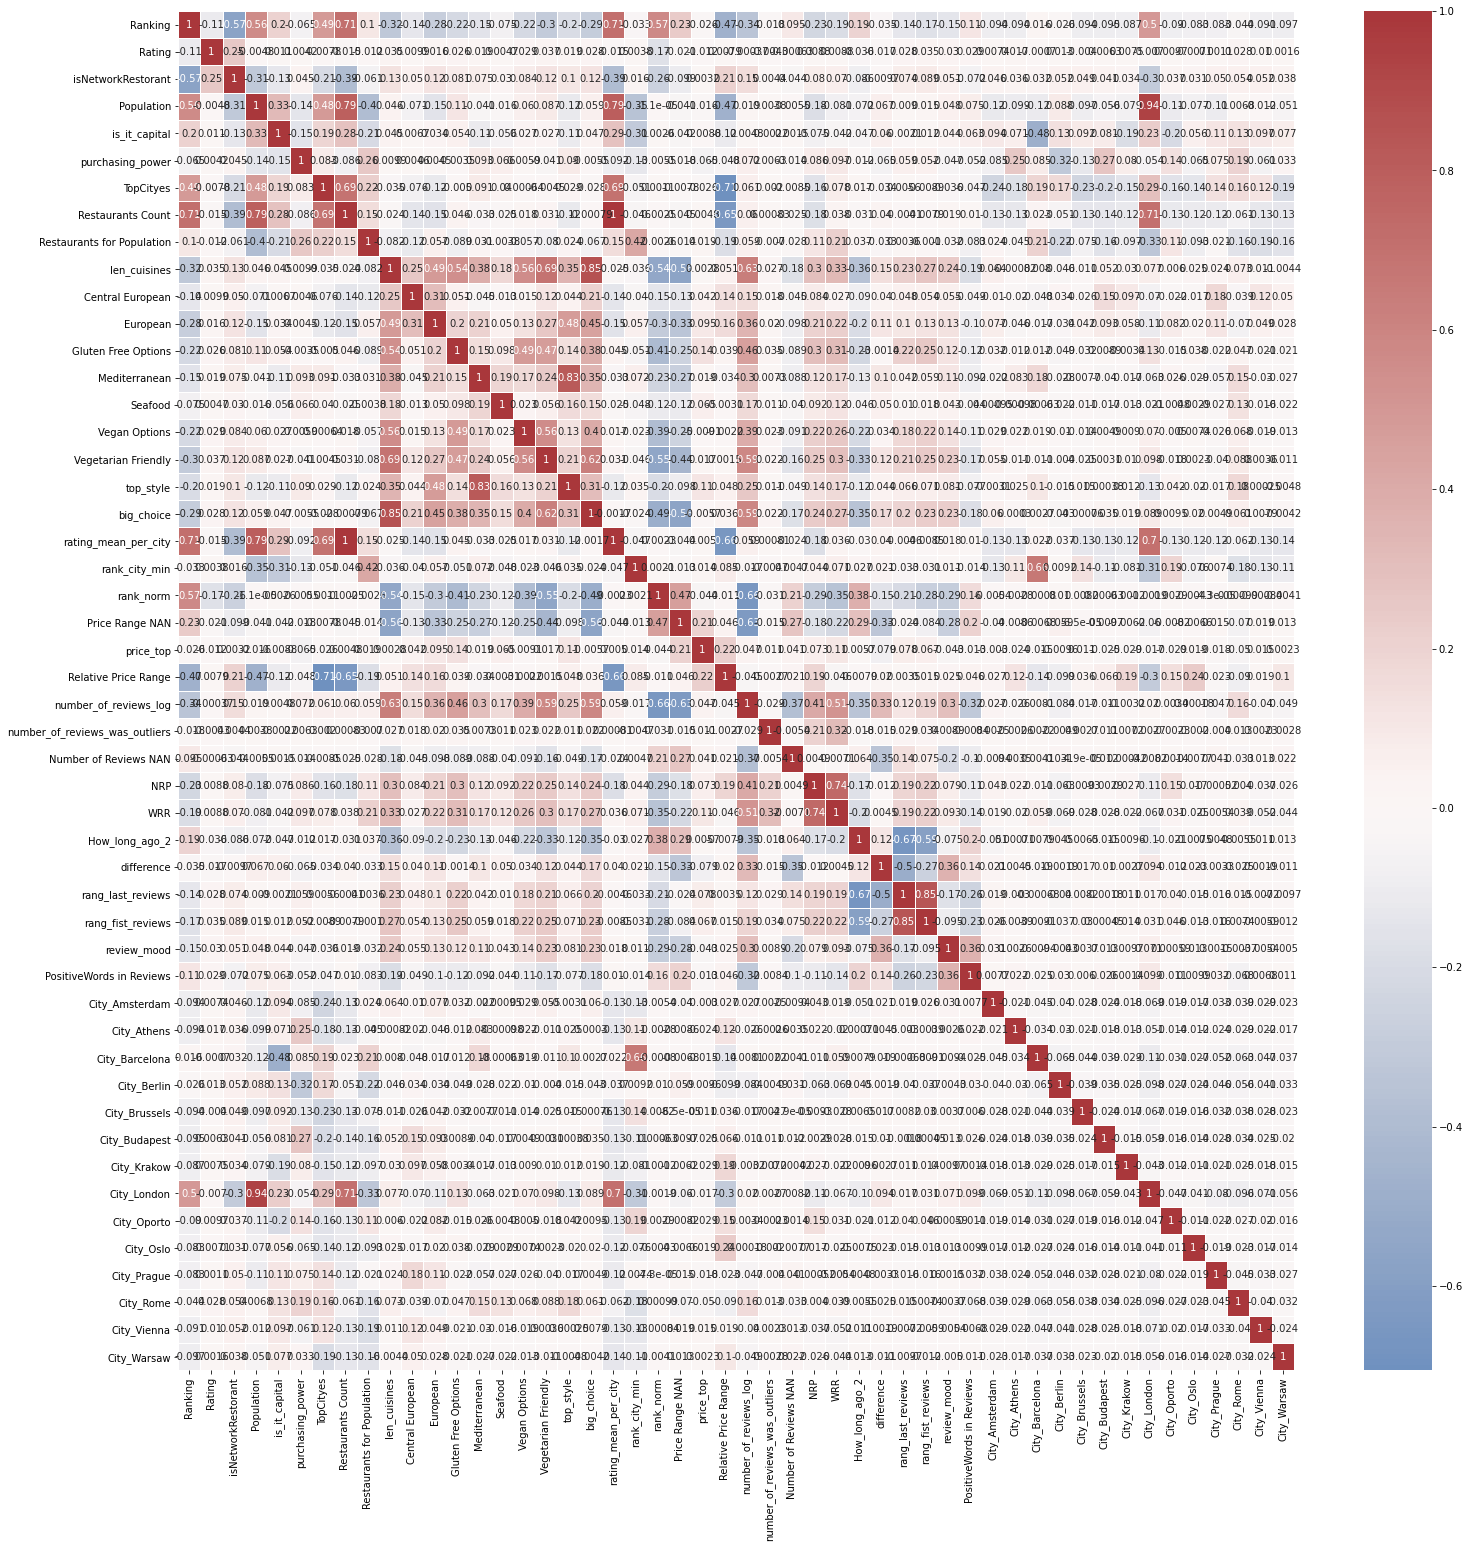

In [52]:
style_for_drop = [
'Afghani',
 'African',
 'Albanian',
 'American',
 'Arabic',
 'Argentinean',
 'Armenian',
 'Asian',
 'Australian',
 'Austrian',
 'Azerbaijani',
 'Balti',
 'Bangladeshi',
 'Bar',
 'Barbecue',
 'Belgian',
 'Brazilian',
 'Brew Pub',
 'British',
 'Burmese',
 'Cafe',
 'Cajun & Creole',
 'Cambodian',
 'Canadian',
 'Caribbean',
 'Caucasian',
 'Central American',
 'Central Asian',
 'Chilean',
 'Chinese',
 'Colombian',
 'Contemporary',
 'Croatian',
 'Cuban',
 'Czech',
 'Danish',
 'Delicatessen',
 'Diner',
 'Dutch',
 'Eastern European',
 'Ecuadorean',
 'Egyptian',
 'Ethiopian',
 'Fast Food',
 'Filipino',
 'French',
 'Fujian',
 'Fusion',
 'Gastropub',
 'Georgian',
 'German',
 'Greek',
 'Grill',
 'Halal',
 'Hawaiian',
 'Healthy',
 'Hungarian',
 'Indian',
 'Indonesian',
 'International',
 'Irish',
 'Israeli',
 'Italian',
 'Jamaican',
 'Japanese',
 'Korean',
 'Kosher',
 'Latin',
 'Latvian',
 'Lebanese',
 'Malaysian',
 'Mexican',
 'Middle Eastern',
 'Minority Chinese',
 'Mongolian',
 'Moroccan',
 'Native American',
 'Nepali',
 'New Zealand',
 'Norwegian',
 'Pakistani',
 'Persian',
 'Peruvian',
 'Pizza',
 'Polish',
 'Polynesian',
 'Portuguese',
 'Pub',
 'Romanian',
 'Russian',
 'Salvadoran',
 'Scandinavian',
 'Scottish',
 'Singaporean',
 'Slovenian',
 'Soups',
 'South American',
 'Southwestern',
 'Spanish',
 'Sri Lankan',
 'Steakhouse',
 'Street Food',
 'Sushi',
 'Swedish',
 'Swiss',
 'Taiwanese',
 'Thai',
 'Tibetan',
 'Tunisian',
 'Turkish',
 'Ukrainian',
 'Uzbek',
 'Venezuelan',
 'Vietnamese',
 'Welsh',
 'Wine Bar',
 'Xinjiang',
 'Yunnan',
 'local',
 'Cuisine Style', 'URL_TA', 'ID_TA','words', 'Reviews', 'Price Range', 'How_long_ago_1', 'rank_city_max','City_nan', 
 'City_Bratislava',
 'City_Copenhagen',
 'City_Dublin',
 'City_Edinburgh',
 'City_Geneva',
 'City_Hamburg',
 'City_Lisbon',
 'City_Helsinki',
 'City_Ljubljana',
 'City_Luxembourg',
 'City_Lyon',
 'City_Madrid',
 'City_Milan',
 'City_Munich',
 'City_Paris',
 'City_Stockholm',
 'City_Zurich']

col_for_drop = ['sample', 'Number of Reviews']
food_corr = food.drop(style_for_drop, axis=1)
food_corr = food_corr.drop(col_for_drop, axis = 1)
#sns.heatmap(food_corr.corr())

correlation = food_corr.corr()
ax = plt.subplots(figsize=(25, 25))
sns.heatmap(correlation, annot=True, cmap='vlag', linewidths=1, center=0)

In [53]:
np.linalg.matrix_rank(correlation)

50

In [54]:
food.columns

Index(['Restaurant_id', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating',
       ...
       'City_Oporto', 'City_Oslo', 'City_Paris', 'City_Prague', 'City_Rome',
       'City_Stockholm', 'City_Vienna', 'City_Warsaw', 'City_Zurich',
       'City_nan'],
      dtype='object', length=202)

In [55]:
# Внесем дополнительные признаки:

rank_p_r_mis = correlation['Ranking']['Price Range NAN']
food['rank_p_r_mis'] = food['Ranking']/rank_p_r_mis
food['p_r_mis_rank'] = food['Price Range NAN']/rank_p_r_mis

food['rank_p_r_mis_2'] = food['Ranking']*rank_p_r_mis

rank_number_mis = correlation['Ranking']['Number of Reviews NAN']
food['rank_number_mis'] = food['Ranking']/rank_number_mis


In [56]:
food.drop(style_for_drop, axis = 1, inplace=True)

In [57]:
df_preproc = food
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Restaurant_id                   50000 non-null  object 
 1   Ranking                         50000 non-null  float64
 2   Number of Reviews               50000 non-null  float64
 3   sample                          50000 non-null  int64  
 4   Rating                          50000 non-null  float64
 5   isNetworkRestorant              50000 non-null  float64
 6   Population                      50000 non-null  int64  
 7   is_it_capital                   50000 non-null  int64  
 8   purchasing_power                50000 non-null  int64  
 9   TopCityes                       50000 non-null  int64  
 10  Restaurants Count               50000 non-null  int64  
 11  Restaurants for Population      50000 non-null  float64
 12  len_cuisines                    

In [58]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.

In [59]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [60]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 60), (40000, 60), (40000, 59), (32000, 59), (8000, 59))

# ML:

In [61]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [62]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [63]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [64]:
y_pred = (y_pred * 2).round()/2

In [65]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1716875


<AxesSubplot:>

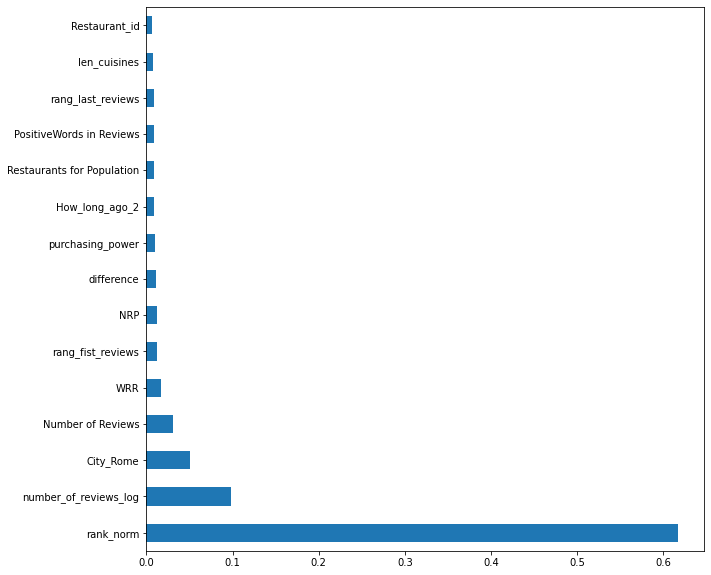

In [66]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission:

In [67]:
test_data.head(10)

,Restaurant_id,Ranking,Number of Reviews,Rating,isNetworkRestorant,Population,is_it_capital,purchasing_power,TopCityes,Restaurants Count,Restaurants for Population,len_cuisines,Central European,European,Gluten Free Options,Mediterranean,Seafood,Vegan Options,Vegetarian Friendly,top_style,big_choice,rating_mean_per_city,rank_city_min,rank_norm,Price Range NAN,...,Day_of_week_2,Month_1,Month_2,rang_last_reviews,rang_fist_reviews,review_mood,PositiveWords in Reviews,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Brussels,City_Budapest,City_Krakow,City_London,City_Oporto,City_Oslo,City_Prague,City_Rome,City_Vienna,City_Warsaw,rank_p_r_mis,p_r_mis_rank,rank_p_r_mis_2,rank_number_mis
0,0,12963.0,4.0,0.0,1.0,2148271,1,22,1,6108,0.002843,2,0,0,0,0,0,0,0,0,0,6938.557138,3.0,0.926840,False,...,0,01,01,0.820156,0.749190,0.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55410.264941,0.000000,3032.639696,136695.840485
1,1,106.0,97.0,0.0,1.0,656229,1,9,0,475,0.000724,5,0,1,1,0,0,1,1,1,1,564.231579,4.0,0.089710,False,...,0,12,10,0.636093,0.624905,1.0,0.010309,0,0,0,0,0,0,0,0,0,0,0,0,0,0,453.096358,0.000000,24.798257,1117.778222
2,2,810.0,28.0,0.0,1.0,488050,1,16,0,745,0.001526,1,0,0,0,0,0,0,1,0,0,885.130201,1.0,0.458357,False,...,3,12,12,0.723994,0.708749,0.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3462.340091,0.000000,189.496116,8541.512828
3,3,1669.0,202.0,0.0,1.0,8909081,1,24,1,7193,0.000807,5,0,1,1,1,0,0,1,4,1,8169.707354,1.0,0.101441,False,...,3,12,11,0.693334,0.627406,1.0,0.004950,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7134.130385,0.000000,390.455578,17599.734457
4,4,37.0,162.0,0.0,1.0,437726,1,39,0,380,0.000868,6,0,1,1,1,1,0,1,4,1,462.428947,3.0,0.038375,False,...,3,02,01,0.992940,0.990995,3.0,0.018519,0,0,0,0,0,0,0,0,0,0,0,0,0,0,158.156276,0.000000,8.655995,390.167870
5,5,5093.0,24.0,0.0,1.0,2148271,1,22,1,6108,0.002843,3,0,0,0,0,0,0,0,0,1,6938.557138,3.0,0.364013,False,...,6,09,09,0.521410,0.411914,1.0,0.041667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21769.997635,0.000000,1191.486073,53706.080042
6,6,3704.0,2.0,0.0,1.0,505526,1,48,1,1647,0.003258,2,0,1,0,0,0,0,0,1,0,1867.330298,1.0,0.996502,False,...,0,01,01,0.820156,0.749190,0.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15832.725553,0.000000,866.535326,39058.967303
7,7,2330.0,124.0,0.0,1.0,1752286,1,51,0,1021,0.000583,1,0,0,0,0,0,0,0,1,0,1219.061704,1.0,0.954900,True,...,0,01,01,0.820156,0.749190,0.0,0.000000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,9959.570880,4.274494,545.093766,24570.030728
8,8,771.0,2.0,0.0,1.0,656229,1,9,0,475,0.000724,2,0,1,0,0,0,0,0,1,0,564.231579,4.0,0.674582,True,...,3,01,10,0.597172,0.950294,2.0,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3295.634828,4.274494,180.372229,8130.254803
9,9,605.0,13.0,0.0,1.0,975904,1,13,0,1033,0.001059,1,0,0,0,0,0,0,0,1,0,1237.482091,1.0,0.245229,True,...,0,12,10,0.636093,0.614440,2.0,0.153846,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2586.068834,4.274494,141.537223,6379.771927


In [68]:
test_data = test_data.drop(['Rating'], axis=1)
test_data

,Restaurant_id,Ranking,Number of Reviews,isNetworkRestorant,Population,is_it_capital,purchasing_power,TopCityes,Restaurants Count,Restaurants for Population,len_cuisines,Central European,European,Gluten Free Options,Mediterranean,Seafood,Vegan Options,Vegetarian Friendly,top_style,big_choice,rating_mean_per_city,rank_city_min,rank_norm,Price Range NAN,price_top,...,Day_of_week_2,Month_1,Month_2,rang_last_reviews,rang_fist_reviews,review_mood,PositiveWords in Reviews,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Brussels,City_Budapest,City_Krakow,City_London,City_Oporto,City_Oslo,City_Prague,City_Rome,City_Vienna,City_Warsaw,rank_p_r_mis,p_r_mis_rank,rank_p_r_mis_2,rank_number_mis
0,0,12963.0,4.0,1.0,2148271,1,22,1,6108,0.002843,2,0,0,0,0,0,0,0,0,0,6938.557138,3.0,0.926840,False,1.0,...,0,01,01,0.820156,0.749190,0.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55410.264941,0.000000,3032.639696,136695.840485
1,1,106.0,97.0,1.0,656229,1,9,0,475,0.000724,5,0,1,1,0,0,1,1,1,1,564.231579,4.0,0.089710,False,1.0,...,0,12,10,0.636093,0.624905,1.0,0.010309,0,0,0,0,0,0,0,0,0,0,0,0,0,0,453.096358,0.000000,24.798257,1117.778222
2,2,810.0,28.0,1.0,488050,1,16,0,745,0.001526,1,0,0,0,0,0,0,1,0,0,885.130201,1.0,0.458357,False,1.0,...,3,12,12,0.723994,0.708749,0.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3462.340091,0.000000,189.496116,8541.512828
3,3,1669.0,202.0,1.0,8909081,1,24,1,7193,0.000807,5,0,1,1,1,0,0,1,4,1,8169.707354,1.0,0.101441,False,1.5,...,3,12,11,0.693334,0.627406,1.0,0.004950,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7134.130385,0.000000,390.455578,17599.734457
4,4,37.0,162.0,1.0,437726,1,39,0,380,0.000868,6,0,1,1,1,1,0,1,4,1,462.428947,3.0,0.038375,False,1.5,...,3,02,01,0.992940,0.990995,3.0,0.018519,0,0,0,0,0,0,0,0,0,0,0,0,0,0,158.156276,0.000000,8.655995,390.167870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,4367.0,28.0,1.0,8909081,1,24,1,7193,0.000807,4,0,0,0,0,0,0,1,0,1,8169.707354,1.0,0.265523,False,0.5,...,1,12,08,0.493970,0.654740,2.0,0.071429,0,0,0,0,0,0,0,1,0,0,0,0,0,0,18666.715035,0.000000,1021.641406,46050.353730
9996,9996,2612.0,2.0,0.0,505526,1,48,1,1647,0.003258,4,0,0,0,0,0,0,0,0,1,1867.330298,1.0,0.702637,False,1.0,...,6,11,11,0.698974,0.595270,0.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11164.978171,0.000000,611.066488,27543.742602
9997,9997,5562.0,2.0,0.0,1399860,0,40,1,2694,0.001924,1,0,0,0,0,0,0,0,1,0,3106.027840,1.0,0.886356,True,1.0,...,0,01,01,0.820156,0.749190,0.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23774.735293,4.274494,1301.206664,58651.721421
9998,9998,4010.0,2.0,0.0,1399860,0,40,1,2694,0.001924,1,0,0,0,0,0,0,0,1,0,3106.027840,1.0,0.638986,True,1.0,...,0,01,01,0.820156,0.749190,0.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17140.720698,4.274494,938.122748,42285.761039


In [69]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [70]:
predict_submission = model.predict(test_data)
predict_submission = (predict_submission * 2).round()/2

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [71]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4. , 4.5])

In [72]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.5
8,id_8,4.0
9,id_9,4.5
